# Recurrent Neural Networks

Let us see how a simple RNN performs doing sentiment analisys on the IMDB dataset. As usual, let us import some modules and libraries.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from keras.datasets import imdb
from keras.preprocessing import sequence

## Processing text data

Deep learning for natural-language processing is pattern recognition applied to words, sentences, and paragraphs, in much the same way that computer vision is pattern recognition applied to pixels.

As expected, deep-learning models do not take as input raw text, they only work with numeric tensors. To deal with this we need to **vectorize** text, which is the process of transforming text into numeric tensors. This can be done in multiple ways:

- Segment text into words, and transform each word into a vector.
- Segment text into characters, and transform each character into a vector.
- Extract n-grams of words or characters, and transform each n-gram into a vector.

The different units into which you can break down text (words, characters, or n-grams) are called **tokens**, and breaking text into such tokens is called **tokenization**. In general, text-vectorization processes consist of applying some tokenization scheme and then associating numeric vectors with the generated tokens. These vectors are fed into deep neural networks. There are multiple ways to associate a vector with a token. Let us talk about two major ones: **one-hot encoding** of tokens, and **token embedding**.

### One-hot encoding

One-hot encoding is the most common, most basic way to turn a token into a vector. It consists of associating a unique integer index with every word and then turning this integer index $i$ into a binary vector of size $n$, which is the size of the vacabulary: the vector is all zeros except for the i-th entry, which is equal to one.

The type of RNN we will implement is *many-to-one*. The idea is to predict if a movie review is *positive* or *negative*. The data we will work with is the **IMDB** database that is already included in `keras`. For now, let us import the data limiting the number of the most frequent words we will handle (`max_features`), and also truncating, or padding, the reviews so that they have `maxlen` words.

In [2]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
tokenizer = Tokenizer(num_words=10)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')
print(word_index)
print(sequences)
print(one_hot_results)

Found 9 unique tokens.
{'the': 1, 'cat': 2, 'sat': 3, 'on': 4, 'mat': 5, 'dog': 6, 'ate': 7, 'my': 8, 'homework': 9}
[[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]
[[0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 1. 1. 1.]]


### Token embedding

This method is mainly used for words, so it is also known as **word embeddings**. Whereas the vectors obtained through one-hot encoding are binary, sparse, and very high-dimensional (same dimensionality as the number of words in the vocabulary), word embeddings are low-dimensional floating-point vectors: that is, dense vectors, as opposed to sparse vectors. So, word embeddings pack more information into far fewer dimensions.

There are two ways to obtain word embeddings: **learn word embeddings** jointly with the main task you care about, and load **pretrained word embeddings**.

#### Learning word embeddings

The simplest way to associate a dense vector with a word is to choose the vector at random. The problem with this approach is that the resulting embedding space has no structure. Something more useful would be to have a space in which the geometric relationships between word vectors should reflect the semantic relationships between these words. Then, word embeddings are meant to map human language into a geometric space.

In real-world word-embedding spaces, common examples of meaningful geometric transformations are **gender** vectors and **plural** vectors. For instance, by adding a `female` vector to the vector `king`, we obtain the vector `queen`. By adding a `plural` vector, we obtain `kings`.Word-embedding spaces typically feature thousands of such interpretable and potentially useful vectors.

Learning a word embedding of a particular task is equivalent to training an extra layer of a neural network, which is known as the `Embedding` layer. This layer can be understood as a dictionary that maps integer indices (which stand for specific words) to dense vectors. It takes integers as input, it looks up these integers in an internal dictionary, and it returns the associated vectors. By the way, this layer needs to be told, at least, the size of the vocabulary we are working with and the dimensionality of the embedding.

To see how this works, let us implement a classifiers that predicts if a movie review is *positive* or *negative*. The data we will work with is the **IMDB** database that is already included in `keras`. For now, let us import the data limiting the number of the most frequent words we will handle (`max_features`), and also truncating the reviews so that they have twenty words at most (`maxlen`).

#### Pretrained word embeddings

When little training data is available, instead of learning word embeddings jointly with the problem we want to solve, we can load embedding vectors from a precomputed embedding space that we know is highly structured and exhibits useful properties. This is analogous to the concept of transfer learning: there is not enough data available to learn truly powerful features on our own, but we expect the features that we need to be fairly generic.

The idea of a dense, low-dimensional embedding space for words, computed in an unsupervised way, was initially explored by Bengio et al. in the early 2000s, but it only started to take off in research and industry applications after the release of one of the most famous and successful word-embedding schemes: the **Word2vec** algorithm, developed by Tomas Mikolov at Google in 2013. Word2vec dimensions capture specific semantic properties, such as gender.

There are various precomputed databases of word embeddings that you can download and use in a `keras` embedding layer. Word2vec is one of them. Another popular one is called **Global Vectors for Word Representation (GloVe)**, which was developed by Stanford researchers in 2014. This embedding technique is based on factorizing a matrix of word co-occurrence statistics. Its developers have made available precomputed embeddings for millions of English tokens, obtained from Wikipedia data and Common Crawl data.

## Sentiment Analysis

The type of RNN we will implement is *many-to-one*. The idea is to predict if a movie review is *positive* or *negative*. The data we will work with is the **IMDB** database that is already included in `keras`. For now, let us import the data limiting the number of the most frequent words we will handle (`max_features`), and also truncating, or padding, the reviews so that they have `maxlen` words.

In [3]:
max_features = 10000
maxlen = 500

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = tf.keras.preprocessing.sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = tf.keras.preprocessing.sequence.pad_sequences(input_test, maxlen=maxlen)

print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
17464789/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


We will build a neural network that will have a `SimpleRNN` layer on top of the `Embedding` layer. In this case, the dimensionality of the embedding space is 32, which means that the dimensionality of the input of the `SimpleRNN` layer is also 32. Notice that this is also the dimensionality of the output of the `SimpleRNN` layer.

By the way, regarding the number of parameters of the `SimpleRNN` layer, the number of trainable parameters of this layer is equal to

$$\dim(W_{aa})+\dim(W_{ax})+\dim(b_a)$$.

In this case, we have that

$$32\times32+32\times32+32\times1=2080.$$

In [4]:
model = Sequential([
                    Embedding(max_features, 32),
                    SimpleRNN(32),
                    Dense(1, activation='sigmoid')
                   ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 322113 (1.23 MB)
Trainable params: 322113 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Let us compile the model. Notice that we are doing binary classification, so the cost function must be `binary_crossentropy`. The evaluation metric will be *accuracy*.

In [5]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

And now we train...

In [6]:
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 25s 146ms/step - loss: 0.6309 - acc: 0.6245 - val_loss: 0.4900 - val_acc: 0.7744
Epoch 2/10
157/157 [==============================] - 23s 147ms/step - loss: 0.4125 - acc: 0.8225 - val_loss: 0.4126 - val_acc: 0.8174
Epoch 3/10
157/157 [==============================] - 23s 148ms/step - loss: 0.3142 - acc: 0.8722 - val_loss: 0.4343 - val_acc: 0.7912
Epoch 4/10
157/157 [==============================] - 24s 154ms/step - loss: 0.2539 - acc: 0.9011 - val_loss: 0.5229 - val_acc: 0.7760
Epoch 5/10
157/157 [==============================] - 23s 146ms/step - loss: 0.2080 - acc: 0.9199 - val_loss: 0.4183 - val_acc: 0.8248
Epoch 6/10
157/157 [==============================] - 23s 146ms/step - loss: 0.1438 - acc: 0.9493 - val_loss: 0.4172 - val_acc: 0.8398
Epoch 7/10
157/157 [==============================] - 22s 141ms/step - loss: 0.0959 - acc: 0.9687 - val_loss: 0.5195 - val_acc: 0.8348
Epoch 8/10
157/157 [==============================] - 2

We get an accuracy of about 80% on the validation set, but we are overfitting the data a bit. Keep in mind that RNNs do not behave that well with long sequences, which could explain in part why the validation accuracy is not higher. Let us visualize these results.

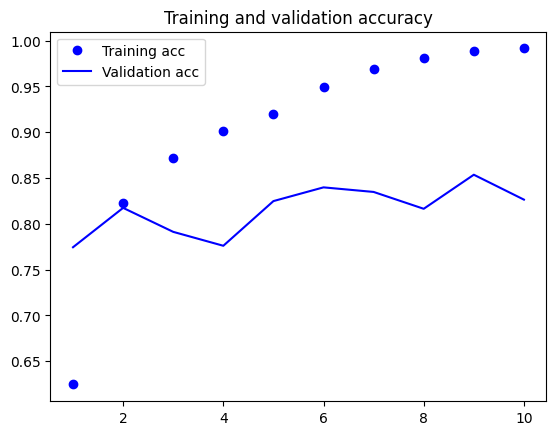

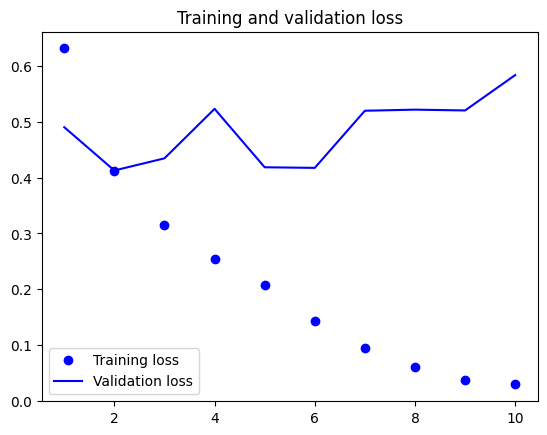

In [7]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## "Deep" RNNs

It is worthwhile to mention that several `SimpleRNN` layers can be stacked on top of each other in order to increase the representational power of a network.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or only the last output for each input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor argument. If we stack `SimpleRNN` layers, all the intermediate `SimpleRNN` layers must have this parameter set to `True`.

 Let us build a model with an extra `SimpleRNN` layer.

In [8]:
model = Sequential([
                    Embedding(max_features, 32),
                    SimpleRNN(32, return_sequences=True),
                    SimpleRNN(32),
                    Dense(1, activation='sigmoid')
                   ])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 324193 (1.24 MB)
Trainable params: 324193 (1.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Let us see how this model performs on the same dataset.

In [9]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 47s 286ms/step - loss: 0.5559 - acc: 0.7030 - val_loss: 0.4599 - val_acc: 0.8004
Epoch 2/10
157/157 [==============================] - 43s 272ms/step - loss: 0.3552 - acc: 0.8517 - val_loss: 0.4667 - val_acc: 0.7902
Epoch 3/10
157/157 [==============================] - 44s 281ms/step - loss: 0.2612 - acc: 0.8961 - val_loss: 0.4430 - val_acc: 0.7942
Epoch 4/10
157/157 [==============================] - 43s 273ms/step - loss: 0.1986 - acc: 0.9240 - val_loss: 0.4285 - val_acc: 0.8610
Epoch 5/10
157/157 [==============================] - 44s 282ms/step - loss: 0.1229 - acc: 0.9560 - val_loss: 0.5457 - val_acc: 0.8466
Epoch 6/10
157/157 [==============================] - 43s 274ms/step - loss: 0.0659 - acc: 0.9779 - val_loss: 0.6840 - val_acc: 0.8192
Epoch 7/10
157/157 [==============================] - 44s 278ms/step - loss: 0.0366 - acc: 0.9878 - val_loss: 0.7073 - val_acc: 0.7928
Epoch 8/10
157/157 [==============================] - 4

As expected, we are still having overfitting. This is due to the fact that we increased the complexity of our model.

## LSTM

`SimpleRNN` is not the only recurrent layer available in Keras. Two other options are `LSTM` and `GRU`. In practical applications, you will usually choose one of these, as `SimpleRNN` tends to be too basic to be of much use. `SimpleRNN` faces a key problem: despite its theoretical ability to retain information from time $t$ related to inputs seen far back in time, in practice it struggles to learn such long-term dependencies. This challenge arises from the *vanishing gradient problem*, similar to that observed in deep feedforward networks, where adding layers can render the network untrainable. Hochreiter, Schmidhuber and Bengio studied the theoretical foundations of this problem in the early 1990s. The `LSTM` and `GRU` layers were designed specifically to address this problem.

Let us look at the `LSTM` layer. Hochreiter and Schmidhuber introduced the **Long Short-Term Memory** (`LSTM`) algorithm in 1997 as the culmination of their work on the vanishing gradient problem. This layer is an evolution of the `SimpleRNN` layer, with a mechanism for retaining information over many time steps. Think of it as a conveyor belt that runs parallel to the sequence you are analysing. Information from the sequence can jump onto this conveyor at any point, travel to a later timestep, and then be retrieved intact when needed. In essence, `LSTM` stores information for later use, preventing older signals from being lost during processing.

Now let us set up the same sentiment analysis application we implemented before, but this time using an `LSTM` layer. The network is very similar to the one with the `SimpleRNN` layer that was just presented.

In [10]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 52s 319ms/step - loss: 0.6062 - acc: 0.6675 - val_loss: 0.4369 - val_acc: 0.8320
Epoch 2/10
157/157 [==============================] - 50s 317ms/step - loss: 0.3587 - acc: 0.8507 - val_loss: 0.3829 - val_acc: 0.8348
Epoch 3/10
157/157 [==============================] - 47s 301ms/step - loss: 0.2692 - acc: 0.8958 - val_loss: 0.3471 - val_acc: 0.8510
Epoch 4/10
157/157 [==============================] - 51s 327ms/step - loss: 0.2296 - acc: 0.9123 - val_loss: 0.4551 - val_acc: 0.8496
Epoch 5/10
157/157 [==============================] - 59s 376ms/step - loss: 0.2015 - acc: 0.9240 - val_loss: 0.3098 - val_acc: 0.8854
Epoch 6/10
157/157 [==============================] - 57s 367ms/step - loss: 0.1716 - acc: 0.9377 - val_loss: 0.3191 - val_acc: 0.8780
Epoch 7/10
157/157 [==============================] - 50s 318ms/step - loss: 0.1531 - acc: 0.9463 - val_loss: 0.4726 - val_acc: 0.8500
Epoch 8/10
157/157 [==============================] - 5

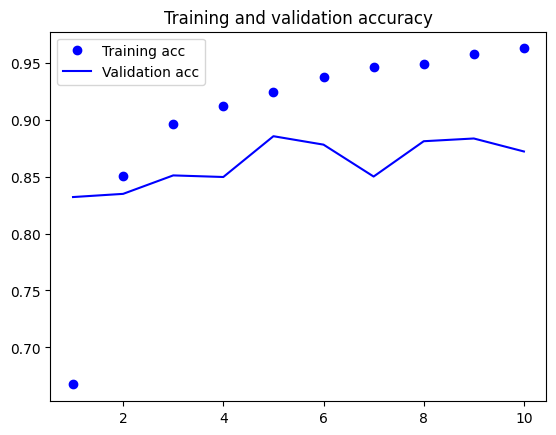

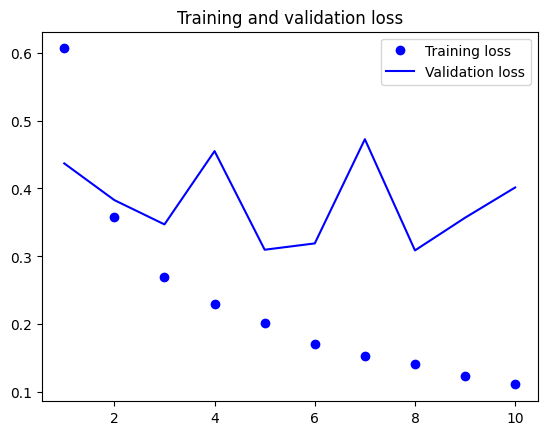

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

This time we achieved a validation accuracy of about 89%, much better than the `SimpleRNN` network. The main reason for this is that `LSTM` suffers much less from the vanishing gradient problem.

## References

[1] Chollet, Francois. *Deep learning with Python*. Simon and Schuster, 2021.

[2] https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks

[3] https://www.v7labs.com/blog/recurrent-neural-networks-guide